In [28]:
import os, re, sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from fuzzywuzzy import fuzz


In [30]:
dirs = os.path.split(os.getcwd())[0]+'/Final/'

In [32]:
data_folder = dirs + 'data_folder/'

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

In [34]:
# creating a ground truth of the the last names of delegates.
# note that if a delegate has the same last name, I include a first initial.
delegates = [
    'Abraham',
    'Aertker',
    'Alario',
    'Alexander',
    'Anzalone',
    'Armentor', 
    'Arnette',
    'Asseff',
    'Avant',
    'Badeaux',
    'Bel',
    'Bergeron',
    'Blair',
    'Bollinger',
    'Brien',
    'Brown',
    'Burns',
    'Burson',
    'Cannon',
    'Carmouche',
    'Casey',
    'Champagne',
    'Chatelain',
    'Chehardy',
    'Colten',
    'Conino', 
    'Conroy',
    'Corne',
    'Cowen',
    "D'Gerolamo",
    'De Blieux',
    'Dennery',
    'Dennis',
    'Derbes',
    'Deshotels',
    'Drew',
    'Dunlap',
    'Duval',
    'Edwards',
    'Elkins',
    'Fayard',
    'Flory',
    'Fontenot',
    'Fowler',
    'Fulco',
    'Gauthier',
    'Giarrusso',
    'Ginn', 
    'Gravel',
    'Grier',
    'Guarisco',
    'Guidry',
    'Hardee', 
    'Hayes', 
    'Haynes',
    'Henry',
    'Hernandez',
    'Jack',
    'Jackson, A.',
    'Jackson, J.',
    'Jenkins',
    'Juneau',
    'Kean',
    'Kelly',
    'Kilbourne',
    'Kilpatrick',
    'Lambert',
    'Landrum',
    'Landry, A.',
    'Landry, E. J.',
    'Lanier',
    'LeBleu',
    'LeBreton',
    'Leigh',
    'Leithman',
    'Lennox',
    'Lowe',
    'McDaniel',
    'Martin',
    'Mauberret',
    'Miller',
    'Mire',
    'Munson',
    'Newton',
    'Nunez',
    "O'Neil",
    'Ourso',
    'Perez',
    'Perkins',
    'Planchard',
    'Rachal',
    'Roy',
    'Rayburn',
    'Reeves',
    'Riecke',
    'Robinson',
    'Roemer',
    'Sandoz',
    'Schmitt',
    'Segura',
    'Shannon',
    'Silverberg',
    'Singletary',
    'Slay',
    'Smith',
    'Soniat',
    'Stagg',
    'Stephenson',
    'Stinson',
    'Stovall',
    'Sutherland',
    'Tapper',
    'Tate',
    'Taylor',
    'Thistlewaite',
    'Thompson',
    'Tobias',
    'Toca',
    'Toomy',
    'Triche',
    'Ullo',
    'Velazquez',
    'Vesich',
    'Vick',
    'Wall',
    'Warren',
    'Weiss',
    'Willis',
    'Winchester',
    'Wisham',
    'Womack',
    'Zervigon'
]

In [36]:
len(delegates) # this is right.

132

In [38]:
######################## Here I gather the votes from volume 1 of the 1973 State constitutional convention #####################

In [40]:
##### This goes through Volume 1 and breaks it indo blocks divided at the word AMENDMENT #####
# open a txt file with python
with open('V1.txt') as F:
    F1 = F.read().split('AMENDMENT')


In [42]:
print(len(F1)) # Vol 1 is divided into 2863 blocks

2863


In [44]:
##### this creates new files from the blocks, but only if they have YE in the block #####
### I chose YE instead of YEAS or YEA because after trying multiple different breaks of the word, this had the most
### votes, but 
counting = 0

block_text_folder = data_folder 

for i, block in enumerate(F1[1:]):
    if 'YE' in block:
        
        ## this is how you write a txt file and exprt to the folder 
        with open(data_folder + 'LA_text_block_' + str("%05d"%counting) + '.txt', 'w') as W:
            W.write(block)
        counting += 1


In [46]:
## I am going to read each individual file from the data folder
## first, making a filelist that contains all the txt files inside the data folder.

file_list = sorted([i for i in os.listdir(data_folder) if i.endswith('.txt')])

In [68]:
##### This code goes through each of the new text files above and divides them into the voting item (pre_item), yeas, nays, not voting, or absent

# Initialize an empty DataFrame
voting_results_v1 = pd.DataFrame(columns=['file_name', 'pre_item', 'YEAS', 'NAYS', 'NOT VOTING', 'ABSENT'])

for files in file_list:
    # Open and read each file
    with open(data_folder + files, 'r', encoding='utf-8') as F:
        F1 = F.read()
    
    # Extract the pre-item section
    pre_item = F1.split(" resul")[0].strip()  # Meta info
    
    # Initialize each item as None
    voting_YEAS_item = None
    voting_NAYS_item = None
    voting_NOTVOTE_item = None
    voting_ABSENT_item = None
    
    ### I chose the splits based on what allowed me to have the most number of votes
    ### I still lose some votes that do not begin with yeas
    ### This may be somewhat important for specific votes, but not for W-NOMINATE, which is what I am prepping the data for
    # Extract YEAS item
    try:
        voting_YEAS_item = F1.split(" roll ")[1].split('YE')[1].split('NA')[0].strip()
    except IndexError:
         pass  # Keep as None if "YE" not found

    # Extract NAYS item
    try:
        voting_NAYS_item = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('NOT ')[0].strip()
    except IndexError:
        pass  # Keep as None if "NA" not found
    
    # Extract NOT VOTING item if present
    try:
        voting_NOTVOTE_item = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('NOT ')[1].split('ABS')[0].strip()
    except IndexError:
        pass  # Set to None if "NOT VOTING" not found
    
    ### I Include this section because sometimes Not Voting is before absent, sometimes it is after, and some times there is only one or the other
    # Extract ABSENT item
    try:
        if voting_NOTVOTE_item is not None:
            # If NOT VOTING item exists, split from it
            voting_ABSENT_item = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('NOT ')[1].split('ABS')[1].split('Total')[0].strip()
        else:
            # If NOT VOTING item does not exist, extract ABSENT directly from NAYS
            voting_ABSENT_item = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('ABS')[1].split('Total')[0].strip()
            # Remove text after "ABS" in NAYS
            if 'ABS' in voting_NAYS_item:
                voting_NAYS_item = voting_NAYS_item.split('ABS')[0].strip()
    except IndexError:
        pass  # Keep as None if "ABSENT" not found

    # Add the extracted data to the DataFrame
    row = pd.DataFrame([[files, pre_item, voting_YEAS_item, voting_NAYS_item, voting_NOTVOTE_item, voting_ABSENT_item]], 
                       columns=['file_name', 'pre_item', 'YEAS', 'NAYS', 'NOT VOTING', 'ABSENT'])
    
    voting_results_v1 = pd.concat([voting_results, row], ignore_index=True)

# Print the final DataFrame to check results
print(voting_results)


                   file_name  \
0    LA_text_block_00000.txt   
1    LA_text_block_00001.txt   
2    LA_text_block_00002.txt   
3    LA_text_block_00003.txt   
4    LA_text_block_00004.txt   
..                       ...   
503  LA_text_block_00503.txt   
504  LA_text_block_00504.txt   
505  LA_text_block_00505.txt   
506  LA_text_block_00506.txt   
507  LA_text_block_00507.txt   

                                              pre_item  \
0    Delegate  Duval  moved  that  the  original  m...   
1    No.  1— On  page  5,  between  lines  10  and ...   
2    No.  2—\nOn  page  4,  strike  out  lines  14 ...   
3    No.  2— On  page  17,  between  lines   1  and...   
4    No.  1—\nRule  53— On  page  17,  line  8,  af...   
..                                                 ...   
503  No.  2—\nOn  page  6,  delete  lines  20  thro...   
504  No.  3— On  page  7,  between  lines  20  and ...   
505  No.  1— On  page  7,   delete  lines   17  thr...   
506  No.  1—\nOn  page  7,  between

In [70]:
voting_results_v1.to_csv('volume_1_voting_results.csv', index=False)

In [27]:
################## For here and below, I do the same thing as I do above but for Volume 2 of the 1973 Louisiana Constitutional Convention #######################

In [72]:
# put the data from volume 2in a new folder called data_folder v2
data_folder_v2 = dirs + 'data_folder_v2/'

if not os.path.exists(data_folder_v2):
    os.makedirs(data_folder_v2)

In [74]:
# open Volume 2 txt file with python
with open('V2.txt') as F2:
    F3 = F2.read().split('Proposal')


In [76]:
print(len(F3))

1865


In [78]:
counting_v2 = 0

block_text_folder_v2 = data_folder_v2 

for i, block in enumerate(F3[1:]):
    if 'YE' in block:
        
        ## this is how you write a txt file and exprt to the folder 
        with open(data_folder_v2 + 'LA_text_block_2_' + str("%05d"%counting_v2) + '.txt', 'w') as W:
            W.write(block)
        counting_v2 += 1

In [80]:
print(counting_v2)

377


In [82]:
file_list_v2 = sorted([i for i in os.listdir(data_folder_v2) if i.endswith('.txt')])

In [84]:
# Initialize an empty DataFrame
voting_results_v2 = pd.DataFrame(columns=['file_name', 'pre_item', 'YEAS', 'NAYS', 'NOT VOTING', 'ABSENT'])

for files in file_list_v2:
    # Open and read each file
    with open(data_folder_v2 + files, 'r', encoding='utf-8') as F:
        F1 = F.read()
    
    # Extract the pre-item section
    pre_item = F1.split(" resul")[0].strip()  # Meta info
    
    # Initialize each item as None
    voting_YEAS_item_v2 = None
    voting_NAYS_item_v2 = None
    voting_NOTVOTE_item_v2 = None
    voting_ABSENT_item_v2 = None
    
    # Extract YEAS item
    try:
        voting_YEAS_item_v2 = F1.split(" roll ")[1].split('YE')[1].split('NA')[0].strip()
    except IndexError:
         pass  # Keep as None if "YEAS" not found

    # Extract NAYS item
    try:
        voting_NAYS_item_v2 = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('NOT ')[0].strip()
    except IndexError:
        pass  # Keep as None if "NAYS" not found
    
    # Extract NOT VOTING item if present
    try:
        voting_NOTVOTE_item_v2 = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('NOT ')[1].split('ABS')[0].strip()
    except IndexError:
        pass  # Set to None if "NOT VOTING" not found

    # Extract ABSENT item
    try:
        if voting_NOTVOTE_item_v2 is not None:
            # If NOT VOTING item exists, split from it
            voting_ABSENT_item = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('NOT ')[1].split('ABS')[1].split('Total')[0].strip()
        else:
            # If NOT VOTING item does not exist, extract ABSENT directly from NAYS
            voting_ABSENT_item_v2 = F1.split(" roll ")[1].split('YE')[1].split('NA')[1].split('ABS')[1].split('Total')[0].strip()
            # Remove text after "ABS" in NAYS
            if 'ABS' in voting_NAYS_item:
                voting_NAYS_item_v2 = voting_NAYS_item_v2.split('ABS')[0].strip()
    except IndexError:
        pass  # Keep as None if "ABSENT" not found

    # Add the extracted data to the DataFrame
    row = pd.DataFrame([[files, pre_item, voting_YEAS_item, voting_NAYS_item, voting_NOTVOTE_item, voting_ABSENT_item]], 
                       columns=['file_name', 'pre_item', 'YEAS', 'NAYS', 'NOT VOTING', 'ABSENT'])
    
    voting_results_v2 = pd.concat([voting_results_v2, row], ignore_index=True)

# Print the final DataFrame to check results
print(voting_results_v2)


                     file_name  \
0    LA_text_block_2_00000.txt   
1    LA_text_block_2_00001.txt   
2    LA_text_block_2_00002.txt   
3    LA_text_block_2_00003.txt   
4    LA_text_block_2_00004.txt   
..                         ...   
372  LA_text_block_2_00372.txt   
373  LA_text_block_2_00373.txt   
374  LA_text_block_2_00374.txt   
375  LA_text_block_2_00375.txt   
376  LA_text_block_2_00376.txt   

                                              pre_item  \
0    and  pass  it  to  its  third  reading.\nA  re...   
1    be  engrossed  and  passed  to  its  third  re...   
2    No.  7  by  Delegate Aertker.  et  al.\nAmend ...   
3    No.  7,  Section  13  was  read,  as amended.\...   
4    No.  7  by  Delegate  Aertker,  et  al.\nAmend...   
..                                                 ...   
372  No.  38  as  amended Section  40  in  PART  IV...   
373  .  A  proposed  amendment  shall  have  a titl...   
374  s.\n(E)  All  rules  and  other  actions  inco...   
375  s\nCom

In [86]:
voting_results_v2.to_csv('volume_2_voting_results.csv', index=False)

In [88]:
# Combine DataFrames by stacking rows (default axis=0)
voting_results = pd.concat([voting_results_v1, voting_results_v2])

# Optionally reset the index if needed
voting_results = voting_results.reset_index(drop=True)


In [90]:
##### This tokenizes the words in each 
# List of exceptions
exceptions = ['Landry, A.', 'Landry, E. J.', 'Jackson, A.', 'Jackson, J.']

# Function to tokenize with exceptions
def tokenize_with_exceptions(text, exceptions):
    if not isinstance(text, str):
        return text  # If not a string, return as is
    
    # Escape the exceptions for regex (to handle special characters like ".")
    escaped_exceptions = [re.escape(token) for token in exceptions]
    
    # Create a regex pattern for exceptions
    exception_pattern = r'|'.join(escaped_exceptions)
    
    # Split text by spaces or newlines, but keep exceptions intact
    pattern = rf'({exception_pattern})|\s+'
    tokens = [token for token in re.split(pattern, text) if token and not token.isspace()]
    return tokens

# Tokenize specified columns
columns_to_tokenize = ['YEAS', 'NAYS', 'NOT VOTING', 'ABSENT']
for col in columns_to_tokenize:
    voting_results[col] = voting_results[col].apply(lambda x: tokenize_with_exceptions(x, exceptions))
    
# Print the updated DataFrame to check results
print(voting_results)


                     file_name  \
0      LA_text_block_00000.txt   
1      LA_text_block_00001.txt   
2      LA_text_block_00002.txt   
3      LA_text_block_00003.txt   
4      LA_text_block_00004.txt   
..                         ...   
881  LA_text_block_2_00372.txt   
882  LA_text_block_2_00373.txt   
883  LA_text_block_2_00374.txt   
884  LA_text_block_2_00375.txt   
885  LA_text_block_2_00376.txt   

                                              pre_item  \
0    Delegate  Duval  moved  that  the  original  m...   
1    No.  1— On  page  5,  between  lines  10  and ...   
2    No.  2—\nOn  page  4,  strike  out  lines  14 ...   
3    No.  2— On  page  17,  between  lines   1  and...   
4    No.  1—\nRule  53— On  page  17,  line  8,  af...   
..                                                 ...   
881  No.  38  as  amended Section  40  in  PART  IV...   
882  .  A  proposed  amendment  shall  have  a titl...   
883  s.\n(E)  All  rules  and  other  actions  inco...   
884  s\nCom

In [92]:
voting_results

,file_name,pre_item,YEAS,NAYS,NOT VOTING,ABSENT
0,LA_text_block_00000.txt,Delegate Duval moved that the original m...,"[AS, Delegates, —, Abraham, Anzalone, Arnette,...","[YS, Giarrusso, Roemer, Ginn, Roy, Gravel, San...",None,"[ENT, PAGE, 6, 1st, Days, Proceedings, —, Janu..."
1,LA_text_block_00001.txt,"No. 1— On page 5, between lines 10 and ...","[AS, Delegates, —, Abraham, Gauthier, Alexande...","[YS, Delegates, —, Aertker, Fowler, Rachal, Al...",None,"[ENT, Delegates, —, Mr., Chairman, Hernandez, ..."
2,LA_text_block_00002.txt,"No. 2—\nOn page 4, strike out lines 14 ...",None,None,None,None
3,LA_text_block_00003.txt,"No. 2— On page 17, between lines 1 and...","[AS, Delegates, —, Abraham, Edwards, Rachal, A...","[YS, Delegates, —, Anzalone, Jackson,, A., Ray...",None,"[ENT, Delegates, —, Mr., Chairman, Colten, Mar..."
4,LA_text_block_00004.txt,"No. 1—\nRule 53— On page 17, line 8, af...","[AS, Delegates—, Aertker, Alexander, Badeaux, ...","[YS, Delegates, —, Abraham, Flory, Newton, Ala...",None,"[ENT, Delegates, —, Mr., Chairman, Roy, Wall, ..."
...,...,...,...,...,...,...
881,LA_text_block_2_00372.txt,No. 38 as amended Section 40 in PART IV...,"[AS, Delegates, —, Alario, Haynes, Roemer, Ber...","[YS, Delegates, —, Aertker, Drew, McDaniel, Ar...","[VOTING, Delegates, —, Mr., Chairman, Comar, M...",None
882,LA_text_block_2_00373.txt,. A proposed amendment shall have a titl...,"[AS, Delegates, —, Alario, Haynes, Roemer, Ber...","[YS, Delegates, —, Aertker, Drew, McDaniel, Ar...","[VOTING, Delegates, —, Mr., Chairman, Comar, M...",None
883,LA_text_block_2_00374.txt,s.\n(E) All rules and other actions inco...,"[AS, Delegates, —, Alario, Haynes, Roemer, Ber...","[YS, Delegates, —, Aertker, Drew, McDaniel, Ar...","[VOTING, Delegates, —, Mr., Chairman, Comar, M...",None
884,LA_text_block_2_00375.txt,s\nCommittee Resolution\nDelegate Resolution...,"[AS, Delegates, —, Alario, Haynes, Roemer, Ber...","[YS, Delegates, —, Aertker, Drew, McDaniel, Ar...","[VOTING, Delegates, —, Mr., Chairman, Comar, M...",None


In [94]:
##### this is to create a dictionary of all unique tokens in all of the columns together #####

# Initialize an empty set to store unique tokens
unique_tokens = set()

# Specify the columns to extract tokens from
columns_to_tokenize = ['YEAS', 'NAYS', 'NOT VOTING', 'ABSENT']

# Iterate over each column and add tokens to the set
for col in columns_to_tokenize:
    voting_results[col].dropna().apply(lambda x: unique_tokens.update(x if isinstance(x, list) else []))

# Convert the set to a sorted list for readability
unique_tokens_list = sorted(unique_tokens)

# Print the unique tokens
print("Unique Tokens:")
for token in unique_tokens_list:
    print(token)


Unique Tokens:
!
"
"5
"Be
"Deep-water
"Functions"
"General
"Governing
"I
"Local
"Louisiana"
"Mi5
"Municipality"
"NT
"NTA"*
"Political
"Powers"
"S
"Structure
"Such
"a
"annon
"clerk"
"convention"
"nay"
"person"
"proposition"
"stitution"
"t»
"undertakings"
%
&
&£
'
':•■
'B)
'Dennis
'i
(
(1)
(10)
(11)
(2)
(21
(3)
(4)
(5)
(6)
(7)
(8
(8)
(9)
(A)
(A1
(A>
(Al
(At
(B)
(B1
(B>
(C)
(D'Gerolamo
(D)
(D>
(Duval
(E)
(E>
(F)
(F>
(F^
(G)
(G1
(G^
(Gl
(H)
(James
(Room
(Substitute
(a'*
(a)
(a>
(ability)
(b)
(c)
(cl
(d)
(e)
(other
(repre-
)
*
*"*
**
*4*
,
,,
,-*
,-J
,-»
,1973,
,J.
-
-*
-..,
-21.
-31
-August
-November
-October
-X
-of
-tveiiy
.
.-
..-
...
.23
.9^,
.:i--'
.J
/
0
0'NeUl
0-»J<H-it
0.
00
033.23
1
1%
1,
1.
1.TAXJ
10
10"
10%
10,
10.
100.
100.00
101.
102.
103.
104.
105.
106
106.
107
107.
108.
109.
10:00
10—
11
11,
11.
110
110.
111.
112.
113.
114.
116.
119.
11:00
11:45
11—
12
12,
12.
12.1,
120
120.
123
123.
12—
13
13,
13.
136.93
14
14,
14.
147.29
14th
15
15%
15,
15.
153
154
155
16
16.
17
17,
17.
17:

In [96]:
##### This cleans each of the tokens to make sure the same tokens with different capitilization can be captured #####
### I then update the unique tokens list so it is only these cleaned tokens

# Function to clean tokens
def clean_token(token):
    # Remove all symbols except apostrophes and remove numbers, then convert to lowercase
    token = re.sub(r"[^\w\s']", '', token)  # Keep only word characters, spaces, and apostrophes
    token = re.sub(r"\d", '', token)  # Remove digits
    return token.lower()  # Convert to lowercase

# Initialize an empty set to store unique tokens
unique_tokens = set()

# Specify the columns to extract tokens from
columns_to_tokenize = ['YEAS', 'NAYS', 'NOT VOTING', 'ABSENT']

# Iterate over each column
for col in columns_to_tokenize:
    voting_results[col].dropna().apply(lambda x: unique_tokens.update(
        [clean_token(token) for token in x if isinstance(x, list)]
    ))

# Convert the set to a sorted list for readability
unique_tokens_list = sorted(unique_tokens)

# Print the unique tokens
print("Unique Tokens:")
for token in unique_tokens_list:
    print(token)


Unique Tokens:

'
'b
'dennis
'i
'neul
_
a
a'
ability
able
abolish
above
abraham
abraharni
absence
absent
absolute
ac
accommodating
accomplish
accomplishment
accordance
according
account
accurately
accused
acquire
acquiring
acquisition
acre
acres
act
acted
acting
action
activites
activities
acts
actually
ad
add
added
addi
addition
additional
address
adequate
adjourn
adjourned
adjournment
adjust
adjustment
adjustments
administer
administered
administrator
admitted
admmistrator
adojourn
adopt
adopted
adoption
adustment
advance
advertise
advertisement
advisor
aeitker
aentker
aerker
aerlker
aertker
affect
affected
affiliates
affirm
affirmation
affirmative
aforesaid
after
afterward
again
against
age
agen
agencies
agency
agenda
agent
aggregate
agree
agreed
agricul
agricultural
aid
aiijil
al
alaiio
alario
alarlo
albert
alexander
all
allegiance
allo
allocate
allocated
allow
alluvial
ally
alone
along
alphonse
already
also
altered
am
amend
amended
amending
amendme
amendment
amendments
america
ame

In [100]:
######## this looks for tokens that are 85 percent similar to the names of delegates #########
#### at 85%, there are 619 unique tokens, at 90% there are around 400, and at 80 there are a little over 1000, so I chose this ####
def filter_delegates(tokens, delegates, threshold=85):
    filtered_tokens = []
    for token in tokens:
        # Check if the token matches any delegate exactly
        if token in delegates:
            filtered_tokens.append(token)
        else:
            # Fuzzy matching: Check if token is similar to any delegate
            for delegate in delegates:
                if fuzz.partial_ratio(token.lower(), delegate.lower()) >= threshold:
                    filtered_tokens.append(token)
                    break  # No need to check further if a match is found
    return filtered_tokens

# Initialize an empty set to store unique tokens
unique_tokens = set()

# Specify the columns to extract tokens from
columns_to_tokenize = ['YEAS', 'NAYS', 'NOT VOTING', 'ABSENT']

# Iterate over each column and filter tokens
for col in columns_to_tokenize:
    # Filter the tokens using fuzzy matching
    voting_results[col].dropna().apply(lambda x: unique_tokens.update(
        filter_delegates([clean_token(token) for token in x if isinstance(x, list)], delegates)
    ))

# Convert the set to a sorted list for readability
unique_tokens_list = sorted(unique_tokens)

# Print the filtered unique tokens
print("Filtered Unique Tokens:")
for token in unique_tokens_list:
    print(token)


Filtered Unique Tokens:
'
'dennis
a
abraham
abraharni
ac
ad
aeitker
aentker
aerlker
aertker
al
alario
alexander
all
allo
allow
ally
alone
am
amette
an
anazalone
and
anmentor
annon
ante
anzalone
anzialone
ap
arid
arm
arme
armenitor
armentor
arnetie
arnetite
arnetle
arnette
arnettte
arti
as
ass
assef
asseff
at
ate
ated
au
avant
b
bad'eaux
badcaux
badeaux
bayburn
be
begin
bel
belief
believe
belonging
below
ber
berg
bergeron
bers
best
blair
blieux
bollinger
bolliniger
bourne
brien
broken
brown
bur
burn
burns
burs
burson
c
ca
campaign
camrouche
can
canmouche
cannon
car
carmoucbe
carmouche
carmouehe
case
casey
caxmouche
cbehardy
ccnroy
cd
ch
cha
chalelain
champagen
champagne
chard
chateiain
chateladn
chatelain
chatelaini
chebardy
chehandy
chehardy
chester
civic
co
colten
con
conino
conroy
corne
cow
cowen
d
d'geriolamo
d'gerloamo
d'geroalmo
d'geroiamo
d'gerolaimo
d'gerolamio
d'gerolamo
d'grerolamo
daniel
de
dear
deed
dele
denenry
denmery
dennery
dennis
derbes
deshatels
desho'els
deshotels
des

In [102]:
##### Here I create a dictionary, where the key is the last name of delegates found in the list delegates
##### This is so that similar values will be matched with the correct delegate so I can properly measure voting behavior

# Initialize delegate_tokens dictionary
delegate_tokens = {delegate: [] for delegate in delegates}  # Initialize delegates
delegate_tokens['Unmatched'] = []  # Initialize Unmatched key

# Function to filter tokens based on fuzzy matching
def filter_delegates(tokens, delegates, threshold=85):
    delegate_dict = {delegate: [] for delegate in delegates}  # Initialize each delegate with an empty list
    for token in tokens:
        matched = False
        # Check if the token matches any delegate exactly
        if token in delegates:
            delegate_dict[token].append(token)
            matched = True
        else:
            # Fuzzy matching: Check if token is similar to any delegate
            for delegate in delegates:
                if fuzz.partial_ratio(token.lower(), delegate.lower()) >= threshold:
                    delegate_dict[delegate].append(token)
                    matched = True
        if not matched:
            delegate_dict['Unmatched'] = delegate_dict.get('Unmatched', []) + [token]
    return delegate_dict

# Process each column
for col in columns_to_tokenize:
    voting_results[col].dropna().apply(lambda x: {
        delegate_tokens.setdefault(delegate, []).extend(tokens) 
        for delegate, tokens in filter_delegates(
            [clean_token(token) for token in x if isinstance(x, list)],
            delegates
        ).items()
    })

# Remove duplicates in each delegate's list
for delegate in delegate_tokens:
    delegate_tokens[delegate] = list(set(delegate_tokens[delegate]))




In [104]:
##### Removes tokens if they are smaller than 2 letters long #####
for delegate in delegate_tokens:
    delegate_tokens[delegate] = [token for token in delegate_tokens[delegate] if len(token) > 2]


In [106]:
delegate_tokens

{'Abraham': ['ham', 'abraharni', 'abraham'],
 'Aertker': ['aentker', 'aeitker', 'aerlker', 'aertker'],
 'Alario': ['alario'],
 'Alexander': ['dear', 'alexander', 'and'],
 'Anzalone': ['lone',
  'one',
  'anzialone',
  'anazalone',
  'alone',
  'anzalone',
  'once'],
 'Armentor': ['ent',
  'arm',
  'tor',
  'arme',
  'armenitor',
  'armentor',
  'ment',
  'anmentor'],
 'Arnette': ['arnette',
  'arnettte',
  'arnetie',
  'tate',
  'arnetle',
  'arnetite',
  'net'],
 'Asseff': ['assef', 'asseff', 'ass'],
 'Avant': ['avant', 'ante'],
 'Badeaux': ['badcaux', "bad'eaux", 'badeaux'],
 'Bel': ['bel', 'believe', 'below', 'belief', 'belonging'],
 'Bergeron': ['berg', 'bergeron', 'ber'],
 'Blair': ['blair'],
 'Bollinger': ['bolliniger', 'ing', 'bollinger'],
 'Brien': ['brien'],
 'Brown': ['own', 'brown', 'owen'],
 'Burns': ['rayiburn',
  'rayburn',
  'bur',
  'burns',
  'raytburn',
  'bayburn',
  'burn'],
 'Burson': ['son', 'sons', 'bur', 'burs', 'burson', 'sion'],
 'Cannon': ['noon', 'cannon', '

In [108]:
######## This removes all tokens that are not seen as related to the delegate names ########

# Get all valid tokens (keys in the delegate_tokens dictionary, excluding 'Unmatched')
valid_tokens = set(delegate_tokens.keys()) - {'Unmatched'}

# Filter tokens in the specified columns to only include those in valid_tokens
for col in columns_to_tokenize:
    voting_results[col] = voting_results[col].apply(
        lambda x: [token for token in x if token in valid_tokens] if isinstance(x, list) else x
    )
voting_results.to_csv("cleaned_voting_results_only_delegates.csv", index=False) 


In [110]:
# Create a reverse mapping from token to its corresponding delegate (key)
token_to_delegate = {}
for delegate, tokens in delegate_tokens.items():
    for token in tokens:
        token_to_delegate[token] = delegate

# Replace tokens in the specified columns with their corresponding keys (delegates)
for col in columns_to_tokenize:
    # Ensure that each value is processed, checking if it's a list
    voting_results[col] = voting_results[col].apply(
        lambda x: [token_to_delegate[token] if token in token_to_delegate else token for token in x]
        if isinstance(x, list) else x
    )

# Inspect the results
print(voting_results.head())
voting_results.to_csv("cleaned_names_only_voting_results.csv", index=False)

                 file_name                                           pre_item  \
0  LA_text_block_00000.txt  Delegate  Duval  moved  that  the  original  m...   
1  LA_text_block_00001.txt  No.  1— On  page  5,  between  lines  10  and ...   
2  LA_text_block_00002.txt  No.  2—\nOn  page  4,  strike  out  lines  14 ...   
3  LA_text_block_00003.txt  No.  2— On  page  17,  between  lines   1  and...   
4  LA_text_block_00004.txt  No.  1—\nRule  53— On  page  17,  line  8,  af...   

                                                YEAS  \
0  [Abraham, Anzalone, Arnette, Asseff, Bergeron,...   
1  [Abraham, Gauthier, Alexander, Ginn, Arnette, ...   
2                                               None   
3  [Abraham, Edwards, Rachal, Alexander, Robinson...   
4  [Aertker, Alexander, Badeaux, Bel, Bergeron, B...   

                                                NAYS NOT VOTING  \
0  [Giarrusso, Roemer, Ginn, Roy, Gravel, Sandoz,...       None   
1  [Aertker, Fowler, Rachal, Alario, Giarr

In [114]:
######## this counts how many rows has no missing data and no empty lists ##########
# Count rows with empty lists
empty_list_counts = voting_results.apply(lambda col: col.apply(lambda x: isinstance(x, list) and len(x) == 0).sum())
print("Empty List Counts:")
print(empty_list_counts)


Empty List Counts:
file_name      0
pre_item       0
YEAS           5
NAYS          41
NOT VOTING     1
ABSENT         1
dtype: int64


In [116]:
##### Count rows with NaN or None #####
no_data_counts = voting_results.isna().sum()
print("No Data Counts:")
print(no_data_counts)


No Data Counts:
file_name       0
pre_item        0
YEAS            9
NAYS           45
NOT VOTING    285
ABSENT        673
dtype: int64


In [118]:
#### this drops all values missing data or empty lists lin the YEAS and NAYS columns #####
### I only remove them completely because these are the two necessary parts for making a spatial model from this data

# Define a condition to check if a row in 'YEA' or 'NAY' has data
condition = ~(
    voting_results['YEAS'].apply(lambda x: isinstance(x, list) and len(x) == 0) | voting_results['YEAS'].isna()
) & ~(
    voting_results['NAYS'].apply(lambda x: isinstance(x, list) and len(x) == 0) | voting_results['NAYS'].isna()
)

# Filter the actual DataFrame based on this condition
voting_results = voting_results[condition]

# Reset the index in the filtered DataFrame if necessary
voting_results.reset_index(drop=True, inplace=True)

# Print the resulting DataFrame to check
print(voting_results)

# Optional: Check the row counts
print("Original number of rows:", len(voting_results))


                     file_name  \
0      LA_text_block_00000.txt   
1      LA_text_block_00001.txt   
2      LA_text_block_00003.txt   
3      LA_text_block_00004.txt   
4      LA_text_block_00005.txt   
..                         ...   
794  LA_text_block_2_00372.txt   
795  LA_text_block_2_00373.txt   
796  LA_text_block_2_00374.txt   
797  LA_text_block_2_00375.txt   
798  LA_text_block_2_00376.txt   

                                              pre_item  \
0    Delegate  Duval  moved  that  the  original  m...   
1    No.  1— On  page  5,  between  lines  10  and ...   
2    No.  2— On  page  17,  between  lines   1  and...   
3    No.  1—\nRule  53— On  page  17,  line  8,  af...   
4    No.  2—\nOn  page  22,  line  28  after  the  ...   
..                                                 ...   
794  No.  38  as  amended Section  40  in  PART  IV...   
795  .  A  proposed  amendment  shall  have  a titl...   
796  s.\n(E)  All  rules  and  other  actions  inco...   
797  s\nCom

In [229]:
# this is how many values I lose
print(886 - 799)

87


In [122]:
##### This block uses the existing data and mutates it so that the rows are each voting item and file that was not dropped
##### and each column is a delegate.
##### if a delegate votes yea on a voting item, they are marked as 1, not voting as 0, nay as -1, absent as -99

# Create the new DataFrame with `file_name` as the index and `delegates` as columns
new_df = pd.DataFrame(index=voting_results['file_name'], columns=delegates)

# Initialize all values in the new DataFrame to NaN (or None) initially
new_df[:] = np.nan

# Loop through each row of the `voting_results` DataFrame to populate the new DataFrame
for idx, row in voting_results.iterrows():
    file_name = row['file_name']  # Get the file name (row index)

    # Loop through each delegate in YEAS, NAYS, and NOT VOTING
    for delegate in delegates:
        if isinstance(row['YEAS'], list) and delegate in row['YEAS']:
            new_df.loc[file_name, delegate] = 1  # Mark as YEA (1)
        elif isinstance(row['NAYS'], list) and delegate in row['NAYS']:
            new_df.loc[file_name, delegate] = -1  # Mark as NAY (-1)
        elif isinstance(row['NOT VOTING'], list) and delegate in row['NOT VOTING']:
            new_df.loc[file_name, delegate] = 0  # Mark as NOT VOTING (0)
        elif isinstance(row['ABSENT'], list) and delegate in row['ABSENT']:
            new_df.loc[file_name, delegate] = -99  # Mark as ABSENT (-99)

# Optional: Reset index if needed
new_df.reset_index(drop=True, inplace=True)

# Print the resulting DataFrame to check
print(new_df)

# Save to CSV if needed
new_df.to_csv("delegate_voting_data.csv", index=False)


    Abraham Aertker Alario Alexander Anzalone Armentor Arnette Asseff Avant  \
0         1       1      1         1        1        1       1      1     1   
1         1      -1     -1         1       -1      -99       1      1     1   
2         1     -99    -99         1       -1      -99       1      1     1   
3        -1       1     -1         1       -1      -99      -1     -1    -1   
4        -1       1      1        -1        1        1      -1     -1     1   
..      ...     ...    ...       ...      ...      ...     ...    ...   ...   
794       0      -1      1         0        0      NaN      -1     -1    -1   
795       0      -1      1         0        0      NaN      -1     -1    -1   
796       0      -1      1         0        0      NaN      -1     -1    -1   
797       0      -1      1         0        0      NaN      -1     -1    -1   
798       0      -1      1         0        0      NaN      -1     -1    -1   

    Badeaux  ... Vesich Vick Wall Warren Weiss Will

In [ ]:
##### Here is some preliminary analyses #####

In [124]:
### pairwise correlation ###

voters_correlation = new_df.corr()

In [126]:
voters_correlation

,Abraham,Aertker,Alario,Alexander,Anzalone,Armentor,Arnette,Asseff,Avant,Badeaux,...,Vesich,Vick,Wall,Warren,Weiss,Willis,Winchester,Wisham,Womack,Zervigon
Abraham,1.000000,0.137562,-0.009938,0.184103,0.263394,-0.137624,0.328728,0.003940,-0.002955,-0.013819,...,0.065852,0.122810,0.117109,0.126701,0.188342,0.177894,0.266388,0.133913,0.139814,0.231834
Aertker,0.137562,1.000000,0.259562,0.511866,0.036858,0.211203,0.223122,-0.040962,0.190353,0.104298,...,0.316005,0.250963,0.438363,0.285330,0.196121,0.145428,0.284655,0.140598,0.293739,0.053663
Alario,-0.009938,0.259562,1.000000,0.079616,0.063367,0.141807,0.156991,0.243812,-0.020000,-0.017676,...,0.132233,0.136808,0.293697,0.160787,0.062315,0.123110,0.078366,0.098613,0.167021,0.095662
Alexander,0.184103,0.511866,0.079616,1.000000,0.017838,0.132999,0.171750,-0.035676,0.065015,0.003252,...,0.273559,0.286562,0.300628,0.214271,-0.039543,0.005728,0.335471,0.118166,0.181150,-0.035603
Anzalone,0.263394,0.036858,0.063367,0.017838,1.000000,0.014134,0.109553,0.250237,-0.021471,0.049375,...,0.227342,0.088143,0.266487,0.094066,0.135764,0.051778,0.078746,0.242088,0.161728,0.084789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Willis,0.177894,0.145428,0.123110,0.005728,0.051778,-0.170094,0.087683,-0.036265,0.104436,0.032611,...,0.486523,0.568270,0.394152,0.636102,0.768206,1.000000,0.541172,0.731642,0.402939,0.824154
Winchester,0.266388,0.284655,0.078366,0.335471,0.078746,-0.061792,0.220194,-0.040501,0.014672,0.062313,...,0.492311,0.575195,0.455835,0.582087,0.546615,0.541172,1.000000,0.527335,0.345239,0.625244
Wisham,0.133913,0.140598,0.098613,0.118166,0.242088,-0.200946,0.118577,-0.059575,0.031330,0.027818,...,0.559478,0.548264,0.493590,0.552223,0.686656,0.731642,0.527335,1.000000,0.476126,0.737660
Womack,0.139814,0.293739,0.167021,0.181150,0.161728,0.093544,0.197959,-0.102646,0.127290,0.280513,...,0.560426,0.359019,0.617647,0.410646,0.403525,0.402939,0.345239,0.476126,1.000000,0.397564


In [132]:
# Creating a table of how many pairs of delegates reah certain thresjholds of correlation
thresholds = np.arange(0.1, 1.0, 0.1)

threshold_counts = []

Loop over each threshold and calculate the number of pairs exceeding the threshold
for threshold in thresholds:
    # Create a boolean matrix where correlations exceed the threshold
    high_corr = np.abs(voters_correlation) >= threshold
    
    # Exclude the diagonal (where variables are correlated with themselves)
    np.fill_diagonal(high_corr.values, False)
    
    # Exclude perfect correlations (100% correlation, i.e., 1 or -1)
    high_corr[voters_correlation == 1] = False
    high_corr[voters_correlation == -1] = False
    
    # Count the number of True values (pairs with correlation above the threshold)
    num_high_corr_pairs = np.triu(high_corr, k=1).sum()
    
    # Append the result to the list
    threshold_counts.append(num_high_corr_pairs)

    Create a DataFrame with the results
threshold_df = pd.DataFrame({
    'Threshold': [f'{int(t*100)}%' for t in thresholds],
    'Number of Pairs': threshold_counts
})

# Print the table
print(threshold_df)


  Threshold  Number of Pairs
0       10%             4688
1       20%             2824
2       30%             1586
3       40%              893
4       50%              454
5       60%              178
6       70%               53
7       80%               20
8       90%               13


In [134]:
# Export the table to LaTeX format (nice formatting)
latex_table = threshold_df.to_latex(index=False, 
                                     column_format="|c|c|c|c|c|c|c|c|c|c|",  # Adjust this based on the number of columns
                                     header=True,
                                     escape=False,
                                     longtable=False,  # Set to True if you want the table to span multiple pages
                                     caption="Correlation Threshold Pairs",  # You can add a caption here if needed
                                     label="tab:correlation_thresholds")  # Optional: adds a label for referencing the table in LaTeX

print(latex_table)


\begin{table}
\caption{Correlation Threshold Pairs}
\label{tab:correlation_thresholds}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|}
\toprule
Threshold & Number of Pairs \\
\midrule
10% & 4688 \\
20% & 2824 \\
30% & 1586 \\
40% & 893 \\
50% & 454 \\
60% & 178 \\
70% & 53 \\
80% & 20 \\
90% & 13 \\
\bottomrule
\end{tabular}
\end{table}



In [136]:
### factor analysis ###

In [138]:
# Check for NaN values
new_df_clean = new_df.fillna(0)  # Replace missing values with 0 or use another strategy

/var/folders/t2/fzr2dy2j0t5ft1xf9nr_ty4m0000gn/T/ipykernel_20414/1847901552.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df_clean = new_df.fillna(0)  # Replace missing values with 0 or use another strategy


In [238]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the features
new_df_scaled = scaler.fit_transform(new_df_clean)

# Convert the scaled data back to a DataFrame for ease of use
new_df_scaled = pd.DataFrame(new_df_scaled, columns=new_df_clean.columns)


In [142]:
# Initialize PCA to extract the number of components
pca = PCA()

# Fit PCA to the scaled data
pca.fit(new_df_scaled)  # Use the scaled dataset


PCA()

In [143]:
explained_variance = pca.explained_variance_

In [146]:
eigenvalues = pca.explained_variance_

# Get the explained variance ratio (percentage of variance explained by each component)
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create a DataFrame to display the results
pca_summary = pd.DataFrame({
    'Principal Component': range(1, len(eigenvalues) + 1),
    'Eigenvalue': eigenvalues,
    'Explained Variance (%)': explained_variance_ratio * 100,
    'Cumulative Explained Variance (%)': cumulative_variance * 100
})

# Display the summary table
print(pca_summary)

     Principal Component    Eigenvalue  Explained Variance (%)  \
0                      1  2.571812e+01            2.038566e+01   
1                      2  9.641927e+00            7.642746e+00   
2                      3  4.961949e+00            3.933126e+00   
3                      4  3.833868e+00            3.038944e+00   
4                      5  3.491101e+00            2.767247e+00   
..                   ...           ...                     ...   
127                  128  1.344706e-31            1.065891e-31   
128                  129  1.344706e-31            1.065891e-31   
129                  130  1.344706e-31            1.065891e-31   
130                  131  1.344706e-31            1.065891e-31   
131                  132  1.344706e-31            1.065891e-31   

     Cumulative Explained Variance (%)  
0                            20.385663  
1                            28.028409  
2                            31.961535  
3                            35.000479  
4 

In [148]:
# Export the summary DataFrame to a CSV file
pca_summary.to_csv('pca_summary.csv', index=False)

In [187]:
# Create LaTeX table string
latex_table = pca_summary.to_latex(index=False, escape=False, column_format="|c|c|c|c|", 
                                   header=["Principal Component", "Eigenvalue", "Explained Variance (%)", "Cumulative Explained Variance (%)"])

# Write to a .tex file
with open('pca_summary_latex.tex', 'w') as f:
    f.write(latex_table)

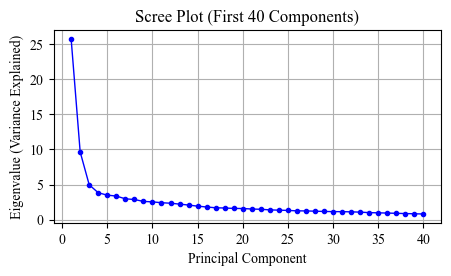

In [240]:
# Set the font to Times New Roman and adjust the font size globally
plt.rcParams['font.family'] = 'Times New Roman'

# Select the first 30-40 components
components_to_plot = explained_variance[:40]  # Change the range as needed

# Create the plot with a smaller figure size
plt.figure(figsize=(5, 2.5))  # Change the figure size to make it smaller
plt.plot(range(1, len(components_to_plot) + 1), components_to_plot, marker='o', linestyle='-', color='b', markersize=3, linewidth=1)
plt.title('Scree Plot (First 40 Components)', fontsize=12)  # Adjust title font size
plt.xlabel('Principal Component', fontsize=10)  # Adjust xlabel font size
plt.ylabel('Eigenvalue (Variance Explained)', fontsize=10)  # Adjust ylabel font size
plt.grid(True)

# Save the plot to a file with a smaller image size
plt.savefig('scree_plot.png', dpi=300)  # Adjust dpi for higher or lower resolution

# Show the plot
plt.show()



In [ ]:
### cluster analysis ###

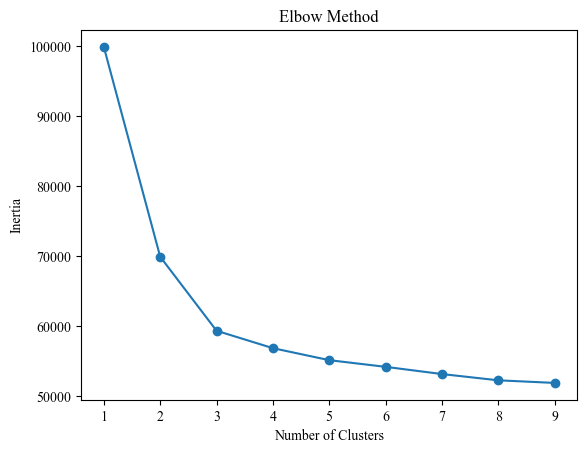

In [158]:
# here I use the elbow method to help me determine how many clusters I might want to use

import matplotlib.pyplot as plt

inertia = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [160]:
# Step 1: Replace -99 with 0
new_df.replace(-99, 0, inplace=True)

# Step 2: Transpose the DataFrame to cluster legislators
data_transposed = new_df.T

# Step 3: Check for any NaN values and fill them with 0
data_transposed.fillna(0, inplace=True)

# Step 4: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed)

# Step 5: Run K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(data_scaled)

# Step 6: Assign cluster labels to each legislator
data_transposed['Cluster'] = kmeans.labels_

# Step 7: Print cluster assignments and cluster centers
print(data_transposed.head())  # Check cluster assignments
print("\nCluster Centers:")
print(kmeans.cluster_centers_)


             0    1    2    3    4    5    6    7    8    9  ...  790  791  \
Abraham    1.0  1.0  1.0 -1.0 -1.0 -1.0  1.0 -1.0  1.0 -1.0  ...  0.0  0.0   
Aertker    1.0 -1.0  0.0  1.0  1.0 -1.0  1.0  1.0  1.0 -1.0  ... -1.0 -1.0   
Alario     1.0 -1.0  0.0 -1.0  1.0  1.0  1.0 -1.0  1.0 -1.0  ...  1.0  1.0   
Alexander  1.0  1.0  1.0  1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  ...  0.0  0.0   
Anzalone   1.0 -1.0 -1.0 -1.0  1.0 -1.0  1.0 -1.0  1.0 -1.0  ...  0.0  0.0   

           792  793  794  795  796  797  798  Cluster  
Abraham    0.0  0.0  0.0  0.0  0.0  0.0  0.0        2  
Aertker   -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0        0  
Alario     1.0  1.0  1.0  1.0  1.0  1.0  1.0        1  
Alexander  0.0  0.0  0.0  0.0  0.0  0.0  0.0        2  
Anzalone   0.0  0.0  0.0  0.0  0.0  0.0  0.0        2  

[5 rows x 800 columns]

Cluster Centers:
[[ 0.20168663  0.15347198 -0.05225347 ... -0.98549007 -0.98549007
  -0.98549007]
 [-0.299634   -0.14407573  0.26153807 ...  1.44173547  1.44173547
   1.4

In [206]:
delegate_clusters = pd.DataFrame({
    'Delegate': data_transposed.index,
    'Cluster': data_transposed['Cluster']
})

# Step 8: Create a list of delegates for each cluster
cluster_delegates = {cluster: delegate_clusters[delegate_clusters['Cluster'] == cluster]['Delegate'].tolist() for cluster in delegate_clusters['Cluster'].unique()}

# Step 9: Convert the dictionary into a DataFrame where each column contains the delegates of each cluster
max_len = max(len(delegates) for delegates in cluster_delegates.values())  # Get the max length to normalize the table

# Create an empty DataFrame with enough rows to hold the largest cluster
pivoted_df = pd.DataFrame(index=range(max_len))

# Fill the DataFrame with delegates, making sure each column contains only delegates from that cluster
for cluster, delegates in cluster_delegates.items():
    cluster_column = pd.Series(delegates)
    pivoted_df[cluster] = cluster_column

# Step 10: Print the pivoted table
print(pivoted_df)

# Optionally save to CSV and LaTeX
pivoted_df.to_csv("delegates_by_cluster_cleaned.csv", index=False)
latex_table = pivoted_df.to_latex(index=False)
with open("delegates_by_cluster_cleaned.tex", "w") as file:
    file.write(latex_table)

print("\nCleaned delegate cluster table exported to CSV and LaTeX!")

                2           0           1
0         Abraham     Aertker      Alario
1       Alexander     Arnette    Bergeron
2        Anzalone      Asseff       Blair
3        Armentor       Avant   Bollinger
4             Bel     Badeaux   Champagne
5           Brown       Brien      Dunlap
6          Burson       Burns       Duval
7          Cannon   Carmouche    Fontenot
8        Chehardy       Casey    Gauthier
9          Colten   Chatelain      Gravel
10          Corne      Conino    Guarisco
11      De Blieux      Conroy      Hardee
12         Derbes       Cowen       Hayes
13      Deshotels  D'Gerolamo      Haynes
14         Fowler     Dennery        Jack
15           Ginn      Dennis     Jenkins
16         Guidry        Drew       Kelly
17          Henry     Edwards  Kilpatrick
18      Hernandez      Elkins     Landrum
19    Jackson, A.      Fayard      Newton
20    Jackson, J.       Flory      Rachal
21      Kilbourne       Fulco         Roy
22     Landry, A.   Giarrusso     

In [175]:
### This is a basic guttman scaling of the roll call voting data. ###

def preprocess_data(new_df):
    """
    Preprocess the roll call voting data for Guttman scaling.
    -1 (nay) and 1 (yea) are converted to binary (0 and 1).
    Non-voting (0) is treated as NaN (missing data).
    """
    # Ensure DataFrame is numeric
    new_df = new_df.astype(float)  # Explicit conversion to float to accommodate NaN
    binary_df = new_df.replace({-1: 0, 1: 1, 0: np.nan})
    return binary_df


def calculate_h(new_df):
    """
    Calculate Loevinger's H scalability coefficient for the dataset.
    H = 1 - (Sum of errors / Maximum possible errors).
    """
    total_errors = 0
    max_errors = 0

    for i in range(new_df.shape[0]):
        for j in range(i + 1, new_df.shape[0]):  # Fixed reference to new_df
            item_i = new_df.iloc[i]
            item_j = new_df.iloc[j]

            pairwise_valid = item_i.notna() & item_j.notna()
            if pairwise_valid.sum() == 0:  # No valid comparisons
                continue

            # Count errors where cumulative patterns are violated
            errors = ((item_i > item_j) & pairwise_valid).sum()
            total_errors += errors

            # Calculate maximum possible errors for this pair
            max_error = pairwise_valid.sum()
            max_errors += max_error

    if max_errors == 0:
        return np.nan  # Avoid division by zero

    return 1 - (total_errors / max_errors)

def guttman_scale_analysis(new_df, axis="items"):
    """
    Conduct a Guttman scale analysis.
    - axis="items": Analyze scalability of voting items.
    - axis="legislators": Analyze scalability of legislators.
    """
    if axis == "legislators":
        new_df = new_df.T  # Transpose if analyzing legislators

    # Preprocess the data for binary format
    preprocessed_df = preprocess_data(new_df)

    # Calculate Loevinger's H
    h = calculate_h(preprocessed_df)
    print(f"Loevinger's H scalability coefficient ({axis}): {h:.3f}")

    if h >= 0.5:
        print("The data fits a Guttman scale well.")
    else:
        print("The data does not fit a Guttman scale well.")

In [177]:
print(guttman_scale_analysis(new_df, axis="items"))


Loevinger's H scalability coefficient (items): 0.773
The data fits a Guttman scale well.
None
